In [7]:
#Importación de las bibliotecas necesarias# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import optuna
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

In [8]:
#  Descarga de los datos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maryna24\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maryna24\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maryna24\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Maryna24\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:

# Lista ampliada de palabras-stop
custom_stopwords = set(stopwords.words('english'))
custom_stopwords.update(['im', 'dont', 'youre', 'ive', 'cant', 'didnt', 'doesnt', 'wont', 'us', 'could', 'would'])

# Función para corregir errores ortográficos
try:
    from autocorrect import Speller
    spell = Speller(lang='en')
    def correct_spelling(text):
        return ' '.join([spell(word) for word in text.split()])
except ImportError:
    def correct_spelling(text):
        return text  # autocorrect no está instalado

def preprocess_text_advanced(text, rare_words=None, frequent_words=None):
    if pd.isna(text):
        return ""
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales y dígitos
    text = re.sub(r'[^a-z\s]', '', text)
    # Corrección ortográfica
    text = correct_spelling(text)
    # Tokenización
    tokens = word_tokenize(text)
    # Eliminar palabras vacías
    tokens = [t for t in tokens if t not in custom_stopwords]
    # Eliminar palabras raras y demasiado frecuentes
    if rare_words:
        tokens = [t for t in tokens if t not in rare_words]
    if frequent_words:
        tokens = [t for t in tokens if t not in frequent_words]
    # Lematización y stemming
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(lemmatizer.lemmatize(t)) for t in tokens]
    return ' '.join(tokens)

# Conteo de frecuencia de palabras para eliminar palabras raras y frecuentes
all_words = ' '.join(data['Text'].astype(str).str.lower()).split()
word_counts = Counter(all_words)
rare_words = set([w for w, c in word_counts.items() if c == 1])
frequent_words = set([w for w, c in word_counts.items() if c > 0.05 * len(data)])  # >5% de los documentos


Tamaño del conjunto de datos: (1000, 15)

Primeras 5 filas:
              CommentId      VideoId  \
0  Ugg2KwwX0V8-aXgCoAEC  04kJtp6pVXI   
1  Ugg2s5AzSPioEXgCoAEC  04kJtp6pVXI   
2  Ugg3dWTOxryFfHgCoAEC  04kJtp6pVXI   
3  Ugg7Gd006w1MPngCoAEC  04kJtp6pVXI   
4  Ugg8FfTbbNF8IngCoAEC  04kJtp6pVXI   

                                                Text  IsToxic  IsAbusive  \
0  If only people would just take a step back and...    False      False   
1  Law enforcement is not trained to shoot to app...     True       True   
2  \nDont you reckon them 'black lives matter' ba...     True       True   
3  There are a very large number of people who do...    False      False   
4  The Arab dude is absolutely right, he should h...    False      False   

   IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  IsNationalist  \
0     False          False      False         False     False          False   
1     False          False      False         False     False          False   
2 

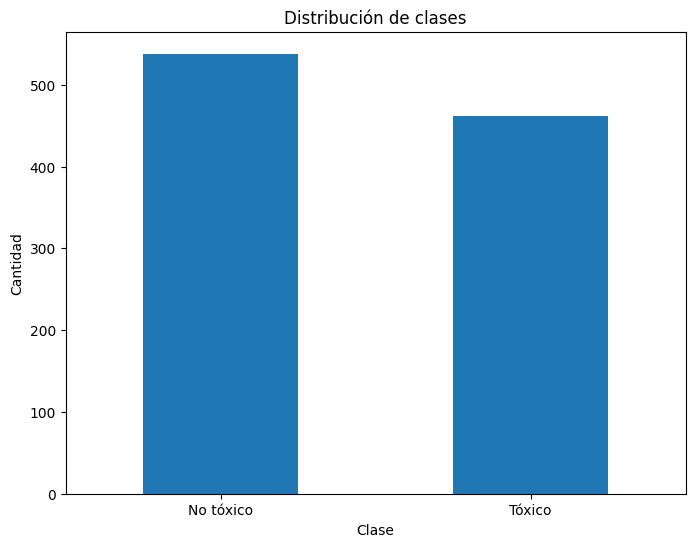

In [11]:
# Carga de datos
data = pd.read_csv('youtoxic_english_1000.csv')

# Exploración de los datos
print("Tamaño del conjunto de datos:", data.shape)
print("\nPrimeras 5 filas:")
print(data.head())

print("\nInformación sobre los datos:")
print(data.info())

print("\nComprobación de valores faltantes:")
print(data.isnull().sum())

# Distribución de clases
print("\nDistribución de clases:")
print(data['IsToxic'].value_counts())

# Visualización de la distribución de clases
plt.figure(figsize=(8, 6))
data['IsToxic'].value_counts().plot(kind='bar')
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['No tóxico', 'Tóxico'], rotation=0)
plt.show()

In [12]:
# Preprocesamiento de texto
print("Preprocesamiento de texto...")
# Aplicación del preprocesamiento
data['processed_text'] = data['Text'].apply(lambda x: preprocess_text_advanced(x, rare_words, frequent_words))

# División de los datos
X = data['processed_text']
y = data['IsToxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Preprocesamiento de texto...
Tamaño del conjunto de entrenamiento: 800
Tamaño del conjunto de prueba: 200


In [13]:
# Función para evaluar el modelo
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluación del modelo con diferentes métricas
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }

    return metrics, y_pred
    

In [14]:
# Optimización de hiperparámetros para Regresión Logística
def optimize_logistic_regression(trial):
    """
    Optimización de hiperparámetros para la regresión logística
    """
    # Parámetros para optimizar
    C = trial.suggest_float('C', 0.01, 100, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    
    # Parámetros para TF-IDF
    max_features = trial.suggest_int('max_features', 1000, 10000)
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)])
    
    # Creación del pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)),
        ('classifier', LogisticRegression(C=C, max_iter=max_iter, solver=solver, random_state=42))
    ])
    
    # Validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    return cv_scores.mean()

In [15]:
# Optimización de hiperparámetros para Random Forest
def optimize_random_forest(trial):
    """
    Optimización de hiperparámetros para Random Forest
    """
    # Parámetros para optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Parámetros para TF-IDF
    max_features = trial.suggest_int('max_features', 1000, 10000)
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)])
    
    # Creación del pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        ))
    ])
    
    # Validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    return cv_scores.mean()

In [16]:
# Optimización de hiperparámetros para SVM
def optimize_svm(trial):
    """
    Optimización de hiperparámetros para SVM
    """
    # Parámetros para optimizar
    C = trial.suggest_float('C', 0.01, 100, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel == 'rbf' else 'scale'
    
    # Parámetros para TF-IDF
    max_features = trial.suggest_int('max_features', 1000, 5000)  # Reducido para SVM
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2)])
    
    # Creación del pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)),
        ('classifier', SVC(C=C, kernel=kernel, gamma=gamma, probability=True, random_state=42))
    ])
    
    # Validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    return cv_scores.mean()

In [17]:
# Optimización de hiperparámetros para Gradient Boosting
def optimize_gradient_boosting(trial):
    """
    Optimización de hiperparámetros para Gradient Boosting
    """
    # Parámetros para optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    # Parámetros para TF-IDF
    max_features = trial.suggest_int('max_features', 1000, 10000)
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)])
    
    # Creación del pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)),
        ('classifier', GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            random_state=42
        ))
    ])
    
    # Validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    return cv_scores.mean()

In [18]:
# Optimización de hiperparámetros para Naive Bayes
def optimize_naive_bayes(trial):
    """
    Optimización de hiperparámetros para Naive Bayes
    """
    # Parámetros para optimizar
    alpha = trial.suggest_float('alpha', 0.1, 10.0)
    
    # Parámetros para TF-IDF
    max_features = trial.suggest_int('max_features', 1000, 10000)
    ngram_range = trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)])
    
    # Creación del pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)),
        ('classifier', MultinomialNB(alpha=alpha))
    ])
    
    # Validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    return cv_scores.mean()

In [19]:
# Ejecución de la optimización para cada modelo
models_optimization = {
    'Logistic Regression': optimize_logistic_regression,
    'Random Forest': optimize_random_forest,
    'SVM': optimize_svm,
    'Gradient Boosting': optimize_gradient_boosting,
    'Naive Bayes': optimize_naive_bayes
}

best_params = {}
best_scores = {}

print("Iniciando la optimización de hiperparámetros...")

for model_name, objective_func in models_optimization.items():
    print(f"\nOptimizando {model_name}...")
    
    # Creación del estudio
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=50)  
    
    best_params[model_name] = study.best_params
    best_scores[model_name] = study.best_value
    
    print(f"Mejor F1-score para {model_name}: {study.best_value:.4f}")
    print(f"Mejores parámetros: {study.best_params}")

[I 2025-07-04 12:27:14,773] A new study created in memory with name: no-name-5027d9f2-0313-4ad9-8f2d-07632dc9ca96
[I 2025-07-04 12:27:14,966] Trial 0 finished with value: 0.057290218553376446 and parameters: {'C': 0.04190868940305564, 'max_iter': 355, 'solver': 'lbfgs', 'max_features': 1352, 'ngram_range': (1, 1)}. Best is trial 0 with value: 0.057290218553376446.


Iniciando la optimización de hiperparámetros...

Optimizando Logistic Regression...


[I 2025-07-04 12:27:15,480] Trial 1 finished with value: 0.4062481939692469 and parameters: {'C': 0.25783202042288195, 'max_iter': 699, 'solver': 'lbfgs', 'max_features': 8573, 'ngram_range': (1, 3)}. Best is trial 1 with value: 0.4062481939692469.
[I 2025-07-04 12:27:15,803] Trial 2 finished with value: 0.642323998875723 and parameters: {'C': 4.247615569339422, 'max_iter': 781, 'solver': 'lbfgs', 'max_features': 3887, 'ngram_range': (1, 2)}. Best is trial 2 with value: 0.642323998875723.
[I 2025-07-04 12:27:16,125] Trial 3 finished with value: 0.6297923168326262 and parameters: {'C': 1.4310462498409255, 'max_iter': 188, 'solver': 'liblinear', 'max_features': 9499, 'ngram_range': (1, 3)}. Best is trial 2 with value: 0.642323998875723.
[I 2025-07-04 12:27:16,307] Trial 4 finished with value: 0.62618466509365 and parameters: {'C': 10.710866915689161, 'max_iter': 277, 'solver': 'liblinear', 'max_features': 7071, 'ngram_range': (1, 1)}. Best is trial 2 with value: 0.642323998875723.
[I 202

Mejor F1-score para Logistic Regression: 0.6553
Mejores parámetros: {'C': 43.80779272405933, 'max_iter': 857, 'solver': 'liblinear', 'max_features': 7747, 'ngram_range': (1, 2)}

Optimizando Random Forest...


[I 2025-07-04 12:27:36,237] Trial 0 finished with value: 0.5874383139454911 and parameters: {'n_estimators': 151, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 1093, 'ngram_range': (1, 2)}. Best is trial 0 with value: 0.5874383139454911.
[I 2025-07-04 12:27:37,448] Trial 1 finished with value: 0.47353741496598634 and parameters: {'n_estimators': 59, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 6560, 'ngram_range': (1, 1)}. Best is trial 0 with value: 0.5874383139454911.
[I 2025-07-04 12:27:40,508] Trial 2 finished with value: 0.5255618804646313 and parameters: {'n_estimators': 121, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 8907, 'ngram_range': (1, 3)}. Best is trial 0 with value: 0.5874383139454911.
[I 2025-07-04 12:27:44,530] Trial 3 finished with value: 0.5186561831421644 and parameters: {'n_estimators': 224, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 6, 'm

Mejor F1-score para Random Forest: 0.5874
Mejores parámetros: {'n_estimators': 151, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 1093, 'ngram_range': (1, 2)}

Optimizando SVM...


[I 2025-07-04 12:30:38,067] Trial 0 finished with value: 0.613904597441861 and parameters: {'C': 7.5410615264955165, 'kernel': 'linear', 'max_features': 2059, 'ngram_range': (1, 1)}. Best is trial 0 with value: 0.613904597441861.
[I 2025-07-04 12:30:40,559] Trial 1 finished with value: 0.6284396545927691 and parameters: {'C': 4.528777679456562, 'kernel': 'linear', 'max_features': 1429, 'ngram_range': (1, 2)}. Best is trial 1 with value: 0.6284396545927691.
[I 2025-07-04 12:30:42,958] Trial 2 finished with value: 0.0 and parameters: {'C': 1.966369286401872, 'kernel': 'rbf', 'gamma': 'auto', 'max_features': 2540, 'ngram_range': (1, 2)}. Best is trial 1 with value: 0.6284396545927691.
[I 2025-07-04 12:30:45,010] Trial 3 finished with value: 0.0 and parameters: {'C': 0.05680002139557461, 'kernel': 'rbf', 'gamma': 'auto', 'max_features': 4015, 'ngram_range': (1, 1)}. Best is trial 1 with value: 0.6284396545927691.
[I 2025-07-04 12:30:47,490] Trial 4 finished with value: 0.05703575394181657 

Mejor F1-score para SVM: 0.6320
Mejores parámetros: {'C': 1.0469882188209618, 'kernel': 'linear', 'max_features': 1438, 'ngram_range': (1, 1)}

Optimizando Gradient Boosting...


[I 2025-07-04 12:32:27,527] Trial 0 finished with value: 0.6451155783074916 and parameters: {'n_estimators': 185, 'learning_rate': 0.15330808659004924, 'max_depth': 3, 'subsample': 0.6636729099585058, 'max_features': 4052, 'ngram_range': (1, 2)}. Best is trial 0 with value: 0.6451155783074916.
[I 2025-07-04 12:32:34,241] Trial 1 finished with value: 0.553715007985492 and parameters: {'n_estimators': 139, 'learning_rate': 0.0304461329974618, 'max_depth': 3, 'subsample': 0.9639133937136155, 'max_features': 7453, 'ngram_range': (1, 1)}. Best is trial 0 with value: 0.6451155783074916.
[I 2025-07-04 12:32:44,310] Trial 2 finished with value: 0.6296357256044344 and parameters: {'n_estimators': 105, 'learning_rate': 0.16861075094140102, 'max_depth': 7, 'subsample': 0.7882637233678289, 'max_features': 1837, 'ngram_range': (1, 1)}. Best is trial 0 with value: 0.6451155783074916.
[I 2025-07-04 12:32:56,284] Trial 3 finished with value: 0.6378986371809238 and parameters: {'n_estimators': 73, 'lea

Mejor F1-score para Gradient Boosting: 0.6574
Mejores parámetros: {'n_estimators': 62, 'learning_rate': 0.18536505877776605, 'max_depth': 9, 'subsample': 0.8161262338996195, 'max_features': 9913, 'ngram_range': (1, 2)}

Optimizando Naive Bayes...


[I 2025-07-04 12:48:58,115] Trial 1 finished with value: 0.588811835477127 and parameters: {'alpha': 2.9279584431536914, 'max_features': 1616, 'ngram_range': (1, 3)}. Best is trial 0 with value: 0.5974524174339086.
[I 2025-07-04 12:48:58,469] Trial 2 finished with value: 0.6483593029406627 and parameters: {'alpha': 0.6371902077836292, 'max_features': 1125, 'ngram_range': (1, 3)}. Best is trial 2 with value: 0.6483593029406627.
[I 2025-07-04 12:48:58,840] Trial 3 finished with value: 0.32188877529728566 and parameters: {'alpha': 8.628844667659928, 'max_features': 7962, 'ngram_range': (1, 3)}. Best is trial 2 with value: 0.6483593029406627.
[I 2025-07-04 12:48:59,275] Trial 4 finished with value: 0.5744788009295574 and parameters: {'alpha': 1.3834520136783102, 'max_features': 8693, 'ngram_range': (1, 3)}. Best is trial 2 with value: 0.6483593029406627.
[I 2025-07-04 12:48:59,663] Trial 5 finished with value: 0.4438251552668029 and parameters: {'alpha': 6.007699522593182, 'max_features': 

Mejor F1-score para Naive Bayes: 0.6618
Mejores parámetros: {'alpha': 0.9195632075073464, 'max_features': 1020, 'ngram_range': (1, 2)}


In [20]:
# Creación de los modelos finales con los parámetros optimizados
final_models = {}

# Regresión Logística
lr_params = best_params['Logistic Regression']
final_models['Logistic Regression'] = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=lr_params['max_features'],
        ngram_range=lr_params['ngram_range']
    )),
    ('classifier', LogisticRegression(
        C=lr_params['C'],
        max_iter=lr_params['max_iter'],
        solver=lr_params['solver'],
        random_state=42
    ))
])

# Random Forest
rf_params = best_params['Random Forest']
final_models['Random Forest'] = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=rf_params['max_features'],
        ngram_range=rf_params['ngram_range']
    )),
    ('classifier', RandomForestClassifier(
        n_estimators=rf_params['n_estimators'],
        max_depth=rf_params['max_depth'],
        min_samples_split=rf_params['min_samples_split'],
        min_samples_leaf=rf_params['min_samples_leaf'],
        random_state=42
    ))
])

# SVM
svm_params = best_params['SVM']
final_models['SVM'] = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=svm_params['max_features'],
        ngram_range=svm_params['ngram_range']
    )),
    ('classifier', SVC(
        C=svm_params['C'],
        kernel=svm_params['kernel'],
        gamma=svm_params.get('gamma', 'scale'),
        probability=True,
        random_state=42
    ))
])

# Gradient Boosting
gb_params = best_params['Gradient Boosting']
final_models['Gradient Boosting'] = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=gb_params['max_features'],
        ngram_range=gb_params['ngram_range']
    )),
    ('classifier', GradientBoostingClassifier(
        n_estimators=gb_params['n_estimators'],
        learning_rate=gb_params['learning_rate'],
        max_depth=gb_params['max_depth'],
        subsample=gb_params['subsample'],
        random_state=42
    ))
])

# Naive Bayes
nb_params = best_params['Naive Bayes']
final_models['Naive Bayes'] = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=nb_params['max_features'],
        ngram_range=nb_params['ngram_range']
    )),
    ('classifier', MultinomialNB(alpha=nb_params['alpha']))
])

# Entrenamiento y evaluación de los modelos finales
results = {}

print("\n" + "="*50)
print("RESULTADOS DE LA EVALUACIÓN DE LOS MODELOS")
print("="*50)

for model_name, model in final_models.items():
    print(f"\n{model_name}:")
    print("-" * 30)
    
    metrics, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[model_name] = metrics
    
    print(f"Exactitud: {metrics['accuracy']:.4f}")
    print(f"Precisión: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    if metrics['roc_auc'] is not None:
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print(f"Matriz de confusión:\n{cm}")
    
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, digits=4))



RESULTADOS DE LA EVALUACIÓN DE LOS MODELOS

Logistic Regression:
------------------------------
Exactitud: 0.7000
Precisión: 0.7162
Recall: 0.5761
F1-score: 0.6386
ROC AUC: 0.7505
Matriz de confusión:
[[87 21]
 [39 53]]

Reporte de clasificación:
              precision    recall  f1-score   support

       False     0.6905    0.8056    0.7436       108
        True     0.7162    0.5761    0.6386        92

    accuracy                         0.7000       200
   macro avg     0.7033    0.6908    0.6911       200
weighted avg     0.7023    0.7000    0.6953       200


Random Forest:
------------------------------
Exactitud: 0.6800
Precisión: 0.7917
Recall: 0.4130
F1-score: 0.5429
ROC AUC: 0.7615
Matriz de confusión:
[[98 10]
 [54 38]]

Reporte de clasificación:
              precision    recall  f1-score   support

       False     0.6447    0.9074    0.7538       108
        True     0.7917    0.4130    0.5429        92

    accuracy                         0.6800       200
   macro 

In [21]:
# Comparación de modelos
results_df = pd.DataFrame(results).T
print("\n" + "="*50)
print("COMPARACIÓN DE MODELOS")
print("="*50)
print(results_df.round(4))



COMPARACIÓN DE MODELOS
                     accuracy  precision  recall      f1  roc_auc
Logistic Regression     0.700     0.7162  0.5761  0.6386   0.7505
Random Forest           0.680     0.7917  0.4130  0.5429   0.7615
SVM                     0.710     0.7429  0.5652  0.6420   0.7552
Gradient Boosting       0.680     0.7000  0.5326  0.6049   0.7271
Naive Bayes             0.705     0.7391  0.5543  0.6335   0.7809


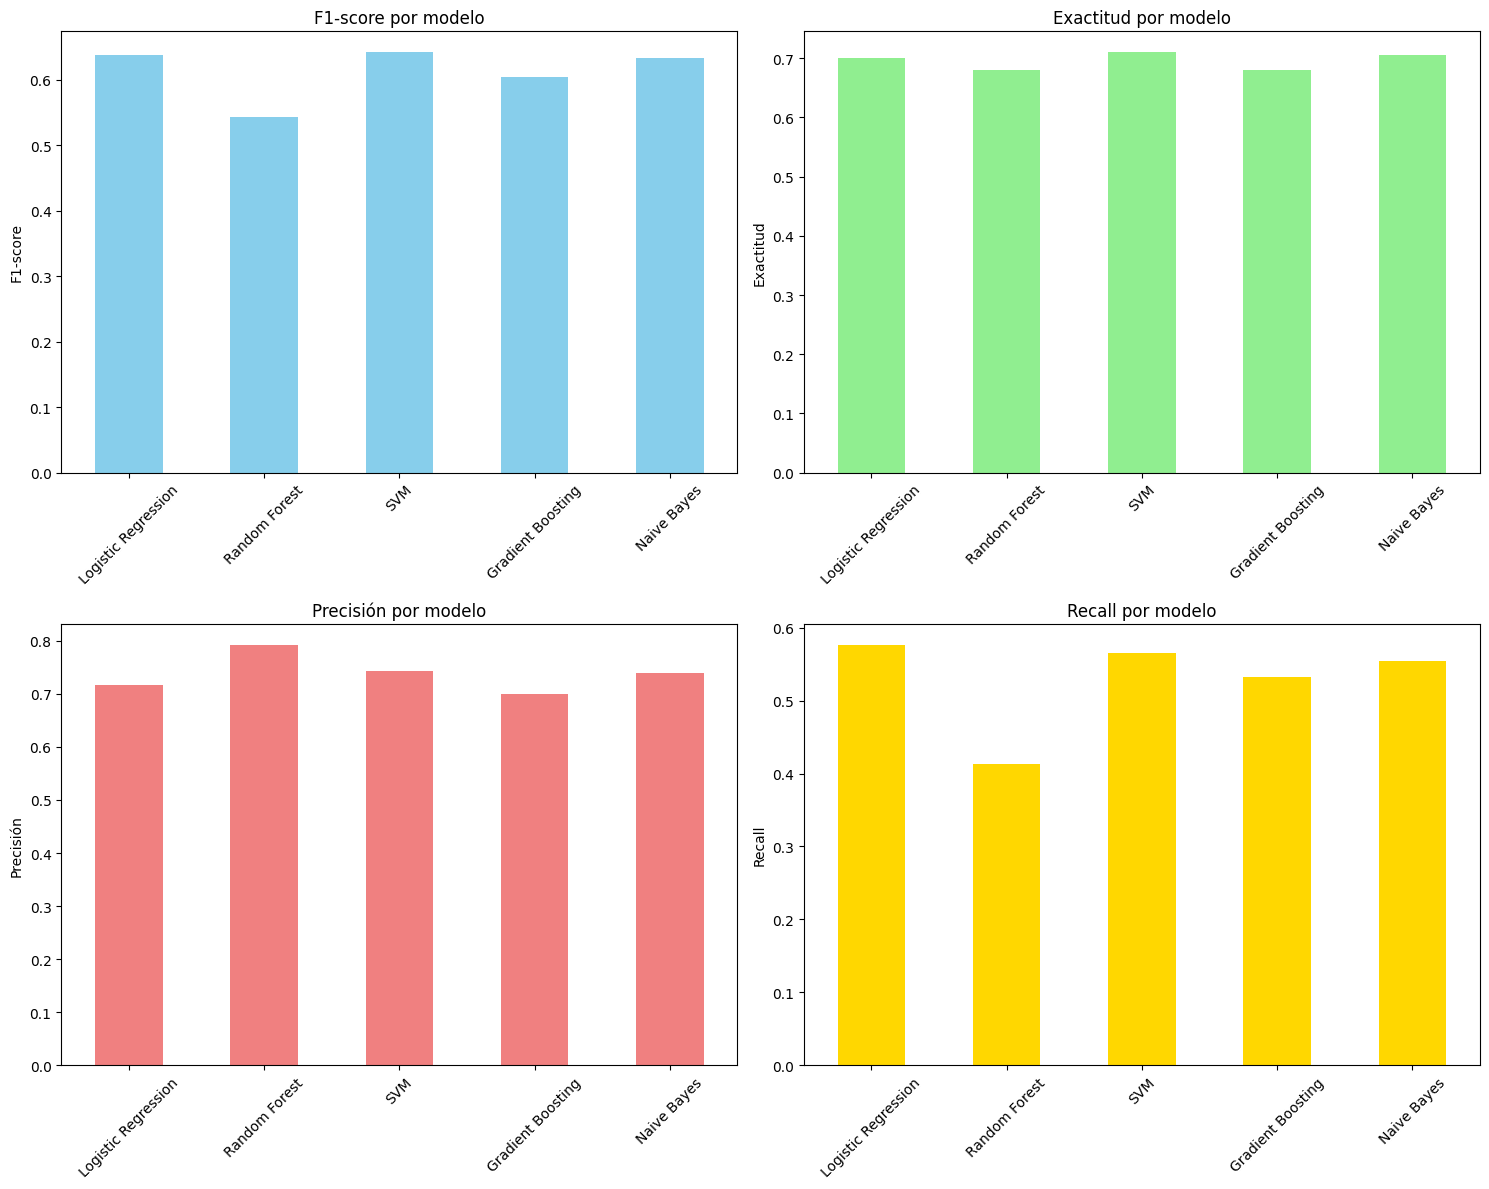

In [22]:
# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# F1-score
results_df['f1'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('F1-score por modelo')
axes[0, 0].set_ylabel('F1-score')
axes[0, 0].tick_params(axis='x', rotation=45)

# Exactitud (Accuracy)
results_df['accuracy'].plot(kind='bar', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Exactitud por modelo')
axes[0, 1].set_ylabel('Exactitud')
axes[0, 1].tick_params(axis='x', rotation=45)

# Precisión
results_df['precision'].plot(kind='bar', ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_title('Precisión por modelo')
axes[1, 0].set_ylabel('Precisión')
axes[1, 0].tick_params(axis='x', rotation=45)

# Recall
results_df['recall'].plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Recall por modelo')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [23]:
# Determinación del mejor modelo
best_model_name = results_df['f1'].idxmax()
print(f"\nMejor modelo según F1-score: {best_model_name}")
print(f"F1-score: {results_df.loc[best_model_name, 'f1']:.4f}")

# Reporte detallado para el mejor modelo
best_model = final_models[best_model_name]
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print(f"\nReporte detallado para {best_model_name}:")
print(classification_report(y_test, y_pred_best))


Mejor modelo según F1-score: SVM
F1-score: 0.6420

Reporte detallado para SVM:
              precision    recall  f1-score   support

       False       0.69      0.83      0.76       108
        True       0.74      0.57      0.64        92

    accuracy                           0.71       200
   macro avg       0.72      0.70      0.70       200
weighted avg       0.72      0.71      0.70       200



In [26]:
# Guardar el mejor modelo
import joblib
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl')
print(f"\nEl mejor modelo se ha guardado como: best_model_{best_model_name.replace(' ', '_').lower()}.pkl")

# Función para predecir la toxicidad de nuevos comentarios
def predict_toxicity(text, model=best_model):
    """
    Predicción de toxicidad para un nuevo comentario
    """
    processed_text = preprocess_text_advanced(text)
    prediction = model.predict([processed_text])[0]
    probability = model.predict_proba([processed_text])[0][1]
    
    return {
        'text': text,
        'is_toxic': bool(prediction),
        'toxicity_probability': probability
    }



El mejor modelo se ha guardado como: best_model_svm.pkl


In [27]:
# Ejemplos de predicciones
test_comments = [
    "This is a great video, thanks for sharing!",
    "You are such an idiot, I hate you!",
    "I disagree with your opinion, but I respect your right to have it.",
    "This content is inappropriate and offensive."
]

print("\n" + "="*50)
print("EJEMPLOS DE PREDICCIONES")
print("="*50)

for comment in test_comments:
    result = predict_toxicity(comment)
    print(f"Comentario: {result['text']}")
    print(f"Tóxico: {result['is_toxic']}")
    print(f"Probabilidad de toxicidad: {result['toxicity_probability']:.4f}")
    print("-" * 30)


EJEMPLOS DE PREDICCIONES
Comentario: This is a great video, thanks for sharing!
Tóxico: False
Probabilidad de toxicidad: 0.1383
------------------------------
Comentario: You are such an idiot, I hate you!
Tóxico: True
Probabilidad de toxicidad: 0.8536
------------------------------
Comentario: I disagree with your opinion, but I respect your right to have it.
Tóxico: False
Probabilidad de toxicidad: 0.2172
------------------------------
Comentario: This content is inappropriate and offensive.
Tóxico: False
Probabilidad de toxicidad: 0.2069
------------------------------
